# Project 

In [1]:
student_name = 'Salih Kilicli'

## Instructions


### Encoding / Decoding

The first part of this project you will write a set of functions to handle the recovery of sparse vectors of dimension $N$.

1. Complete the function `create_observation_matrix` to generate an observation matrix with dimension $m \times N$ containing values drawn from a standard normal distribution scaled by $\sqrt{\frac{\pi}{2m}}$.
2. Complete the function `create_observation_vector` to create the observation vector by projecting a sparse input vector to a lower dimension using the observation matrix.
3. Run your implementation of the functions above using a sparse random input signal generated by the given function, `create_sparse_signal`.  You can use `matplotlib.pyplot` to plot the input sparse signal (see Helper functions below).
4. Write the $\ell_1$-minimization problem as a linear programming problem. To find its solution, complete the function `optimize` which uses `scipy.optimize.linprog`, `scipy.optimize.minimize` or cvxpy.
5. Run your implementation and use the provided code blocks to output the error and results.  Verify that the original input signal has been appropriately recovered.


### Wavelet Image Processing

In this section you will use Wavelets to generate a sparse signal from a grayscal image, and then utilize the encoding/decoding functions you have already completed from the previous section to encode and decode the wavelet coefficients.

1. Complete the function `decompose_image` to write the input image as a sum of Haar wavelets (see [`pywt.wavedec2`](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html?highlight=wavedec2#d-multilevel-decomposition-using-wavedec2)). The function should return both the coefficient array and slicing data (see [`pywt.coeffs_to_array`](https://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html)).
2. Complete the function `reconstruct_image` to reconstruct an image from the Haar coefficients and slicing data (see [`pywt.array_to_coeffs`](https://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html#splitting-concatenated-coefficient-array-back-into-its-components) and [`pywt.waverec2`](https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2)).
3. Verify your implementation of `decompose_image` and `reconstruct_image`.  In the **Test Code** section load the __shapes2_32.jpg__ image from file (this function is provided), and run the subsequent code blocks to decompose and reconstruct the input image as well as compare the results.  
4. Complete the function `create_sparse_wavelet_signal`.  This function will return a copy of the input array where the component of `s` largest values are the same and the remaining `N-s` values are set to zero. 
5. Run the remainder of the code blocks in **Test Code** and verify that you are able to reconstruct an approximation of the original image using the recovered sparse coefficient vector.  Values for `m` and `s` have been chosen for you, but you should play with these values and write additional tests to see their affect on the results. What is your conclusion on the effect of `m` and `s`? Explain why you reach this conclusion.



## Submitting Your Assignment

You will submit your completed assignment in two formats:

- Jupyter Notebook (.ipynb)
- HTML (.html)

##### Jupyter Notebook (.ipynb)
You may directly use this notebook to complete your assignment or you may use an external editor/IDE of your choice.  However, to submit your code please ensure that your code works in this notebook.  
  
##### HTML (.html)
To create an HTML file for your assignment simply select `File > Download as > HTML (.html)` from within the Jupyter Notebook.  
  
Both files should be uploaded to [Canvas](https://canvas.tamu.edu).

## scipy.optimize and cvxpy

This project could be completed with any optimization package, but we recommend that you first try with scipy.optimize, and if you wish additionally with [cvxpy](https://www.cvxpy.org/index.html).  We will provide solutions for both scipy.optimize and cvxpy after you submit your project.

Also, note that the `scipy.optimize.linprog` supports only `'interior-point'`, `'revised simplex'` and `'simplex'`, while CVX supports many others which may provide better results.

If you are using the Anaconda package as was suggested at the beginning of the course you will already have scipy.optimize.  However, you may not have cvxpy.  The cvxpy package provides a much more understandable and easier means of implementing and performing various optimizations.  If you wish to try this check out the [cvxpy installation instructions](https://www.cvxpy.org/install/) for your system.  **Note**: Your system may have multiple installations of python, anaconda, and/or pip.  Do yourself a favor and verify all paths to your installation and to the conda, pip or other tools you are using to install external packages.  If you use the wrong one the package will not be available in your working environment.

## Helper Functions

The following block contains several plotting functions along with a function to create a random sparse signal, a function to output the status of optimize, and a function to load images using PIL.

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import math
import numpy as np
import seaborn as sns
from scipy.optimize import linprog, minimize
from PIL import Image
import cvxpy as cp
import pywt

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_sparse_vectors(vec_a, vec_b, **kwargs):
    """
    Plots the passed arrays in one or three separate subplots.
    If 'full' is specifed as True then the following three subplots
    will be generated:
        - The topmost subplot contains both arrays; vec_a will be 
          drawn first twice as thick as vec_b.  The title will be 
          set if 'title' is specified.
        - The bottom left subplot contains only the vec_a, and will
          be given a tilte is 'title_a' is specified. 
        - The bottom right subplot contains only the vec_b, and will
          be given a tilte is 'title_b' is specified.  
    If 'full' is not specified or is False, then a single subplot 
    will generated as follows:
        - The plot contains both arrays; vec_a will be drawn first
          twice as thick as vec_b.  The title will be set if 'title'
          is specified.
    """
    use_full_layout = 'full' in kwargs and kwargs['full']
    
    if use_full_layout:
        fig = plt.figure(figsize=(20, 8))
        gs = fig.add_gridspec(2, 2)
    else:
        fig = plt.figure(figsize=(20, 4))
        gs = fig.add_gridspec(1, 1)
    
    ax = fig.add_subplot(gs[0,:])
    if 'title' in kwargs:
        ax.set_title(kwargs['title'], fontsize=10)
    plt.plot(vec_a, 'g', linewidth=4)
    plt.plot(vec_b, 'r', linewidth=2)

    if use_full_layout:
        ax = fig.add_subplot(gs[1,0])
        if 'title_a' in kwargs:
            ax.set_title(kwargs['title_a'], fontsize=10)
        plt.plot(vec_a, 'g', linewidth=2)

        ax = fig.add_subplot(gs[1,1])
        if 'title_b' in kwargs:
            ax.set_title(kwargs['title_b'], fontsize=10)
        plt.plot(vec_b, 'r', linewidth=2)

    plt.show()
    
    
def plot_image_comparison(img_left, img_right, title_left, title_right):
    """
    Plots img_left and img_right as subplots on the same row.
    The title_left and title_right are supplied to img_left
    and img_right, respectively.
    """
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img_left, cmap=plt.cm.gray)
    ax.set_title(title_left, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(img_right, cmap=plt.cm.gray)
    ax.set_title(title_right, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    
    
def create_sparse_signal(N, s):
    """
    Returns a length N array containing s random values drawn from
    a standard normal distribution.  The remaining N-s values are 
    set to zero.
    """
    # Create a mask with `s` randomly selected elements set to True
    mask = np.full(N, False)
    mask[:s] = True
    np.random.shuffle(mask)

    # Define an s-sparse vector using random values
    x = np.zeros(N)
    x[mask] = np.random.randn(s)
    
    return x


def output_linprog_status(res):
    """
    Outputs the state of the optimization at the return of scipy.optimize.linprog
    or scipy.optimize.minimize.
    """
    print('Message:', res.message)
    print('Success:', res.success)
    print('Objective Value:', res.fun)
    print('Number of Iterations:', res.nit)

    print('Exit Status:')
    if res.status == 0:
        print('  Optimization proceeding nominally.')
    elif res.status == 1:
        print('  Iteration limit reached.')
    elif res.status == 2:
        print('  Problem appears to be infeasible.')
    elif res.status == 3:
        print('  Problem appears to be unbounded.')
    elif res.status == 4:
        print('  Numerical difficulties encountered.')
    else:
        print('Unknown.')    

        
# Alias for linprog status output - minimize and linprog return the same structure
output_minimize_status = output_linprog_status


def output_cvxpy_status(problem):
    # Output optimation final status
    print('Objective Value:', problem.value)
    print('Number of Iterations:', problem.solver_stats.num_iters)

    print('Exit Status:', problem.status)

    
def output_opt_status(opt_res):
    if type(opt_res) is cp.problems.problem.Problem:
        output_cvxpy_status(opt_res)
    else:
        output_linprog_status(opt_res) # minimize uses the same function

        
def load_image(filename):
    """
    Loads an image, specified by filename, and returns a 2D array whose values 
    are in the range [0,1].
    """
    # load the image 
    img = Image.open(filename).convert('L')
    # convert image data to numpy array with values in [0,1]
    img_arr = np.divide(np.asarray(img), 255.0)
    
    return img_arr

## Your Solution: Encoding / Decoding

Complete the `create_observation_matrix()` and `create_observation_vector()` functions below, and test them using the **Test Code** below.

In [4]:
def create_observation_matrix(m, N):
    """
    This function returns an mxN array of random values from a
    standard normal distribution scaled by sqrt( pi / 2m ).
    """
    return np.sqrt(np.pi/(2*m)) * np.random.standard_normal(size=(m, N))

def create_observation_vector(A, x):
    """
    This function uses the observation matrix A (mxN) to project the 
    sparse vector x (Nx1) to a lower dimensional space.  The reduced
    vector (mx1) is returned.
    """
    return np.dot(A, x)

Complete the `optimize()` function below using `scipy.optimize.linprog`, `scipy.optimize.minimize` or cvxpy.

**Hint**: If using linprog, when using the interior point method, consider setting `'sparse':True`, `'cholesky':False`, and `'sym_pos':False` in the `options` dictionary (see [scipy.optimize.linprog](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html#scipy-optimize-linprog) and [options for interior-point](https://docs.scipy.org/doc/scipy/reference/optimize.linprog-interior-point.html#linprog-method-interior-point)).

## Problem statement

The $\ell_1$-norm linear programming problem for finding the sparse solution $x$ is:

$$\text{minimize:} \quad \|z\|_{\ell^1}$$
$$ \text{subject to:} \ Az = y $$

where $z \in \mathcal{R}^n$, or simply: 

$$ x = argmin_{z \in \mathcal{R}^n} \|z\|_{\ell^1} \quad \text{subject to} \quad Az = y.$$

__Note:__ The $\ell_1$-minimization problem above is __not__ a __linear program__ since the objective function $\|z\|_1=\sum_{i=1}^N|z_i|$ is __not linear__. 
However, we can transform it to a linear problem with a simple trick. Notice, the problem above is equivalent to the following linear program:

$$ \text{minimize:} \quad  \sum_{i=1}^N x_i$$
$$\text{subject to:}  \  Az=y \\
			        \quad x_i\ge z_i \qquad \text{for all } i=1,\dots, N$$
                    
$$\quad x_i\ge -z_i \qquad \text{for all } i=1,\dots, N.$$.



In [5]:
def optimize(A, y):
    """
    Uses the observation matrix and observation vector to produce
    the objective function, equality constraints, inequality 
    constraints, and bounds to be passed to linprog, minimize or cvxpy.
    
     minimize ||z||_1 = sum(np.abs(z)) subject to A @ z = y for z in R^n
            
                            or equivalently
                            
     minimize sum(x) subject to A @ z = y, -z_i <= x_i <= z_i for every i
    
    This function then performs the optimization and returns the
    structure returned by linprog or minimize (or problem & minimal value from cvxpy).
    """
    # create the variable to be minimized
    x = cp.Variable(shape = A.shape[1])
    z = cp.Variable(shape = A.shape[1])
    
    # create the constraint Az = y
    constraints = [A @ z == y, 
                   x >=  z,
                   x >= -z] 
    
    # create the objective var to minimize
    objective = cp.Minimize(cp.sum(x))
    
    # set up the problem
    prob = cp.Problem(objective, constraints)
    
    # solve the problem
    prob.solve(solver = 'ECOS') # ECOS, OSQP, SCS -> no need to install
    
    # Number of nonzero elements (above a threshold 1e-8) in the solution
    print(f'Feasible ({prob.status}) solution in R^{z.shape[0]} has {sum(np.abs(z.value)>=1e-8)} nonzeros.')
    
    # return the minimized objective value
    return prob, z.value

## Test Code

After completing the above functions run the following code blocks to view your results.

### Setup

The following code block uses your implementation to generate a sparse input vector of length N, as well as creates the observation matrix, A, and the observation vector, y.

In [6]:
# Original signal dimension (N=500 default)
N = 500

# Reduced dimension (m=150 default)
m = 150

# Sparsity - number of non-zeros in signal (s=20 default)
s = 20

# Define an s-sparse vector using random values
x = create_sparse_signal(N, s)

# Define the observation matrix, R^{m x N}
A = create_observation_matrix(m, N)

# Define the observation vector, R^m
y = create_observation_vector(A, x)

In [7]:
prob, z = optimize(A, y)

nonzeros_z = z[np.abs(z) >= 1e-8]

print(f'\nnonzeros_z.shape = {nonzeros_z.shape}')
print(f'\nnonzeros_z = \n\n{nonzeros_z}')

Feasible (optimal) solution in R^500 has 20 nonzeros.

nonzeros_z.shape = (20,)

nonzeros_z = 

[ 0.03815071  0.73893797 -1.73143026  0.95339646  0.91925605 -0.43211342
  0.7911034   0.73075551 -0.13404511  0.56158518 -1.1332936  -0.01450314
  0.04174507 -0.54135962  1.17035387  0.36356738 -0.09519428  0.9292345
 -1.20620132  0.32404099]


The following code block plots the original sparse signal.

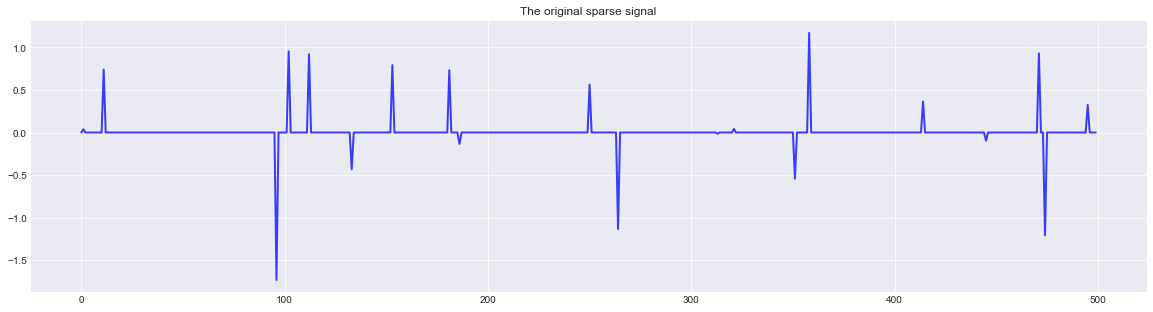

In [8]:
fig = plt.figure(figsize=(20, 5))
plt.plot(x, 'b', linewidth=2, alpha=0.75)
plt.title('The original sparse signal')
plt.show()

### Perform Optimization

The following code block runs your optimiation, outputs the status, reovery error and number of non-zeros in the result and thresholded result.

Feasible (optimal) solution in R^500 has 20 nonzeros.
Objective Value: 12.850267839412183
Number of Iterations: 12
Exit Status: optimal
L²-recovery error: 1.680103561242266e-10
Result vector has 500 non-zeros out of 500
Thresholded result vector has 20 non-zeros out of 500


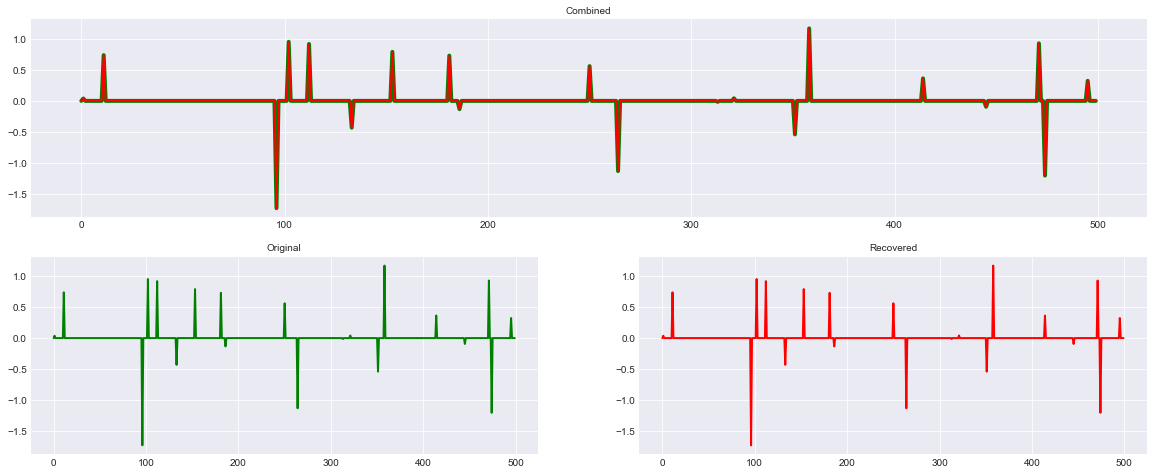

In [9]:
opt_res, x_star = optimize(A, y)

# Output optimation final status 
output_opt_status(opt_res)

# Output the L2 recovery error, norm(x-xstar)
print('L\u00B2-recovery error:', np.linalg.norm(x - x_star))

# Output the number of non-zeros 
print('Result vector has', np.count_nonzero(x_star), 'non-zeros out of', N)

# Threshold near-zero values and count 'non-zeros'
z = x_star.copy()

z[np.abs(z) < 1e-8] = 0  # set 'small' values to zero

print('Thresholded result vector has', np.count_nonzero(z), 'non-zeros out of', N)

# plot the input and recovered vectors
plot_sparse_vectors(x, z, full=True, title='Combined',  title_a='Original', title_b='Recovered')

## Your Solution: Wavelets


In [10]:
def decompose_image(img_arr, wavelet='haar'):
    """
    This function takes a 2D array of image coefficients in the 
    range [0,1] and uses pywt.wavedec2 to decompose those 
    coefficients into wavelet coefficients.  It also uses 
    pywt.coeffs_to_array to reorder those coefficients and create
    our coefficient array and slicing data.  
    The coefficients and slicing data are both returned by this 
    function.
    
    Visit: https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families
    """
    
    # decompose the wavelet into its coefficients
    coeffs = pywt.wavedec2(img_arr, wavelet)
    
    # reorder the coefficients to a single array in (coeff_arr, coeff_slices) format
    array = pywt.coeffs_to_array(coeffs, padding=0)
    
    return array


def reconstruct_image(coeffs_arr, coeffs_slices, wavelet='haar'):
    """
    This function takes wavelet coefficients and slicing data 
    (as produced by pywt.coeffs_to_array) and uses pywt.array_to_coeffs
    and pywt.waverec2 to reconstruct an image (a 2D array).
    The reconstructed image is returned.
    """
    
    # convert the array into wavelet coefficients
    coeffs = pywt.array_to_coeffs(coeffs_arr, coeffs_slices, output_format='wavedec2')
    
    # use wavelet coefficients to reconstruct the 2D image
    image = pywt.waverec2(coeffs, wavelet='haar')
    
    return image

In [11]:
def create_sparse_wavelet_signal(coeffs_arr, s):
    """
    Returns a copy of coeffs_arr where all values are zero except
    the s largest values, no matter where they appear in the array.
    """

    # create a 1D copy of 2D coeffs_arr array
    # coeffs_arr.ravel() = coeffs_arr.flatten() = coeffs_arr.reshape(-1)
    coeffs = coeffs_arr.copy().ravel() 
    
    # create a 1D array of zeros
    s_largest = np.zeros(coeffs.shape)
    
    # sort the coeffs array (in abs value) and select the indices with largest values
    # notice argpartition finds smallest values so use -array to find largest ones
    flat_indices = np.argpartition(-np.absolute(coeffs), s-1)[:s]
    
    # assign s largest elements to s_largest, rest 0
    s_largest[flat_indices] = coeffs[flat_indices]
    
    return s_largest

__Example:__ Selecting s-largest value (in abs value) of an array A

In [12]:
S = 5
assert (S < A.size), 's should be smaller than size of A'

# create an example 2D array
A = np.array([[5, 3, 0], [-2, -4, 1], [3, 2, -6]])
print(f'A =\n\n{A}')

flat_A = A.ravel()
print(f'\nflattened(A) = {flat_A}')
      
flat_indices = np.argpartition(-np.abs(flat_A), S-1)[:S]
print(f'\nIndex of largest {s} elements = {flat_indices}')

B = np.zeros(flat_A.shape)
B[flat_indices] = flat_A[flat_indices]
print(f'\nLargest {S} elements of A = B = \n\n{B}')

print(f'\nReshaped(B) =\n\n{B.reshape(A.shape)}')

A =

[[ 5  3  0]
 [-2 -4  1]
 [ 3  2 -6]]

flattened(A) = [ 5  3  0 -2 -4  1  3  2 -6]

Index of largest 20 elements = [8 0 4 1 6]

Largest 5 elements of A = B = 

[ 5.  3.  0.  0. -4.  0.  3.  0. -6.]

Reshaped(B) =

[[ 5.  3.  0.]
 [ 0. -4.  0.]
 [ 3.  0. -6.]]


## Test Code

After completing the above functions run the following code blocks to view your results.

The following code block uses your implementation to ...

### Setup: Load the input image

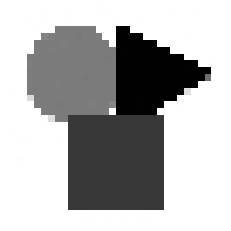

In [13]:
plt.figure(figsize=(10, 4))
img_arr = load_image('shapes2_32.jpg')
plt.imshow(img_arr, cmap='gray');
plt.axis('off');

### Setup: Wavelet Decomposition

Decompose the `img_arr` into wavelet coefficients and some bookkeeping data used by `pywt.wavedec2` and `pywt.waverec2`.

In [14]:
# Transform the 2D image data and get the separated coefficient and slice indexing data
coeffs_arr, coeffs_slices = decompose_image(img_arr)

### Setup: Wavelet Reconstruction - Sanity Check

Sanity Check: Reconstruct the image from your decomposition to ensure that it matches the original input.

L∞ error between original and reconstruction: 4.0190073491430667e-14


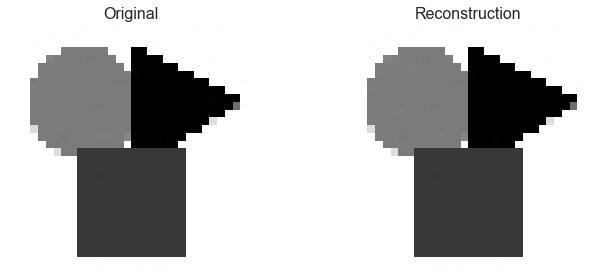

In [15]:
img_recon = reconstruct_image(coeffs_arr, coeffs_slices)

# Compute difference between img_arr and img_recon
print('L\u221E error between original and reconstruction:', np.linalg.norm(img_arr - img_recon, np.inf))

# Visually verify the reconstruction output
plot_image_comparison(img_arr, img_recon, 'Original', 'Reconstruction')

### Setup: Remove 'small' coefficients

The following block sets our values for `N`, `m` and `s`, and creates a sparse input signal from the input `coeffs_arr`.

In [16]:
# Find the number of coefficients in the signal
N = coeffs_arr.shape[0] * coeffs_arr.shape[1]   # coeffs_arr.size is the same thing (simpler)

# Choose m 
m = math.floor(.7 * N)

# Choose s
s = math.floor(.4 * m)

# Create our sparse input signal from the wavelet coefficients
x = create_sparse_wavelet_signal(coeffs_arr, s)

print('Signal Length (N) =', N)
print('Reduced Dimension (m) =', m)
print('Sparsity (s) =', s)

Signal Length (N) = 1024
Reduced Dimension (m) = 716
Sparsity (s) = 286


Plot the input `coeffs_arr` and the sparse `x` on top of one another.

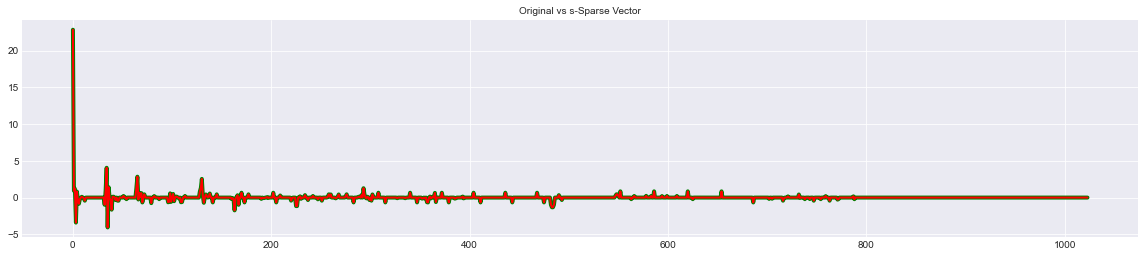

In [17]:
plot_sparse_vectors(coeffs_arr.reshape(N), x, title='Original vs s-Sparse Vector')

### Setup: Wavelet Reconstruction (2) - Sanity Check

Verify that the sparse version of the coefficient array can be used to reconstruct the original image as well.

L∞ error between original and sparse reconstruction: 0.016789215686292436


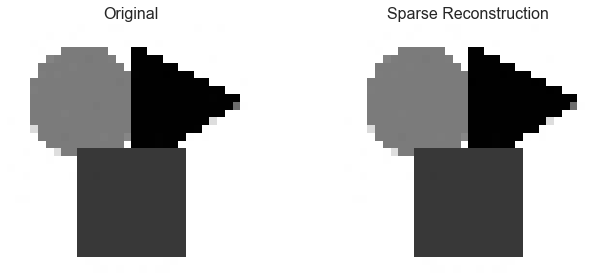

In [18]:
# Reshape the sparse coefficient array to match the original input image
sparse_coeffs_arr = x.reshape(coeffs_arr.shape)

# reconstruct the image from the sparse coefficient array
sparse_img_recon = reconstruct_image(sparse_coeffs_arr, coeffs_slices)

# Compute difference between img_arr and sparse_img_recon
print('L\u221E error between original and sparse reconstruction:', 
       np.linalg.norm(img_arr - sparse_img_recon, np.inf))

# Visually verify the reconstruction output
plot_image_comparison(img_arr, sparse_img_recon, 'Original', 'Sparse Reconstruction')

### Setup: Create observation matrix and vector

Use the previous implementation of `create_observation_matrix` and `create_observation_vector` to generate the observation vector from `x`.

In [19]:
# Define the observation matrix, R^{m x N}
A = create_observation_matrix(m, N)

# Define the observation vector, R^m
y = create_observation_vector(A, x)

### Perform Optimization (this may take some time)

The following code blocks runs your optimization, outputs the status, recovery error and number of non-zeros in the result and thresholded result.

Feasible (optimal) solution in R^1024 has 286 nonzeros.
Objective Value: 115.23676469715092
Number of Iterations: 15
Exit Status: optimal
L²-recovery error: 2.1270347955117434e-09
Result Vector has 1024 non-zeros out of 1024
Result Vector has 286 non-zeros out of 1024


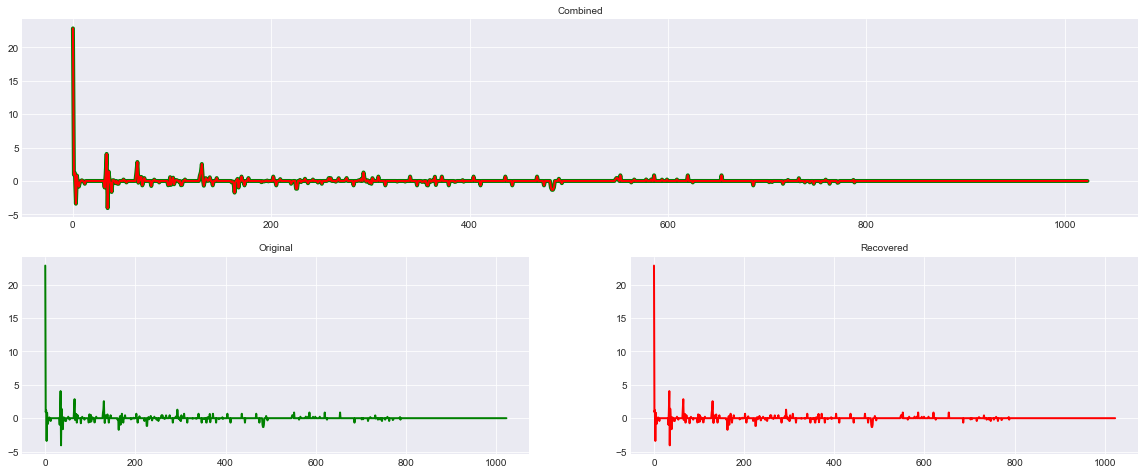

In [20]:
opt_res, xstar = optimize(A, y)

# Output optimation final status 
output_opt_status(opt_res)

# Output the L2 recovery error, norm(x-xstar)
print('L\u00B2-recovery error:', np.linalg.norm(x-xstar))

# Output the number of non-zeros 
print('Result Vector has', np.count_nonzero(xstar), 'non-zeros out of', N)

# Threshold near-zero values and count 'non-zeros'
z = xstar.copy()
z[np.abs(z) < 1e-8] = 0
print('Result Vector has', np.count_nonzero(z), 'non-zeros out of', N)

# plot the input and recovered vectors
plot_sparse_vectors(x, z, full=True,
                    title='Combined', 
                    title_a='Original',
                    title_b='Recovered')

### Wavelet Reconstruct from L1-minimization

Use the reconstructed values to perform the wavelet reconstruction and compare with the original input.


L∞ between original and reconstruction:, 0.01678921618558593



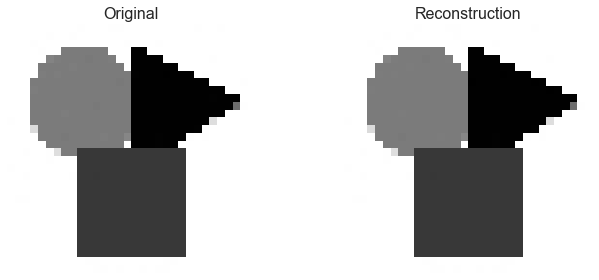

In [21]:
# Reshape the reconstructed coefficient array to match the original input image
coeffs_decode_arr = z.reshape(coeffs_arr.shape[0], coeffs_arr.shape[1])

# reconstruct the image from the reconstructed coefficient array
l1_img_recon = reconstruct_image(coeffs_decode_arr, coeffs_slices)

# Compute difference between img_arr and img_recon
print(f'\nL\u221E between original and reconstruction:, {np.linalg.norm(img_arr - l1_img_recon, np.inf)}\n')

# Visually verify the reconstruction output
plot_image_comparison(img_arr, l1_img_recon, 'Original', 'Reconstruction')

## Your Solution: `m` and `s`

What is your conclusion on the effect of `m` and `s`? Explain why you reach this conclusion.

As the number of non-sparse ($s$) elements _decreases_ the signal seems to be _smoother_, and in the extreme case where $s=0$ it is just a straigth line. $s$ behaves like the __amplitude__ of the signal, whereas the reduced dimension size $m$ more behaves like the $\mathbf{\dfrac{1}{wavelength}}$ and the signal _streches out_ as $m$ _decreases_. Below, some test examples for various $m$ and $s$ values given.


m = 716, s = 286

Feasible (optimal) solution in R^1024 has 286 nonzeros.
Result Vector has 286 non-zeros out of 1024


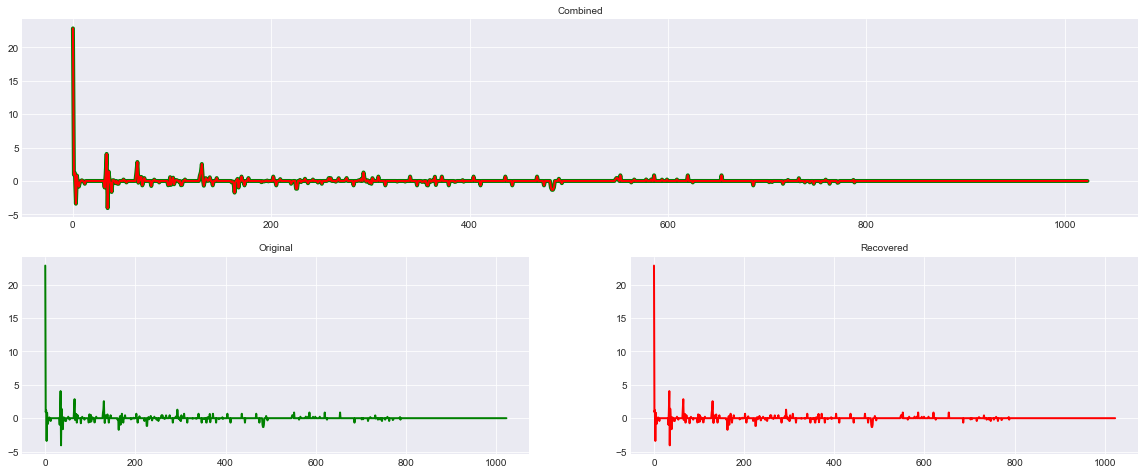

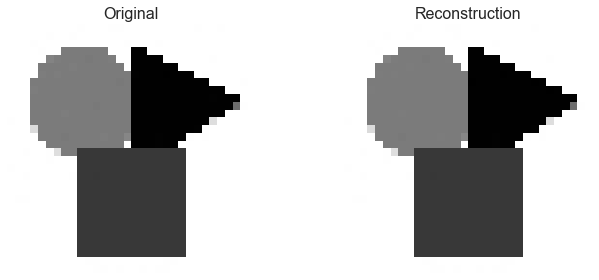

---

For m = 716, s = 286:

L² - recovery error: 6.280729785906563e-10
L∞ - recovery error: 0.016789215662609047


---


m = 600, s = 286

Feasible (optimal) solution in R^1024 has 616 nonzeros.
Result Vector has 616 non-zeros out of 1024


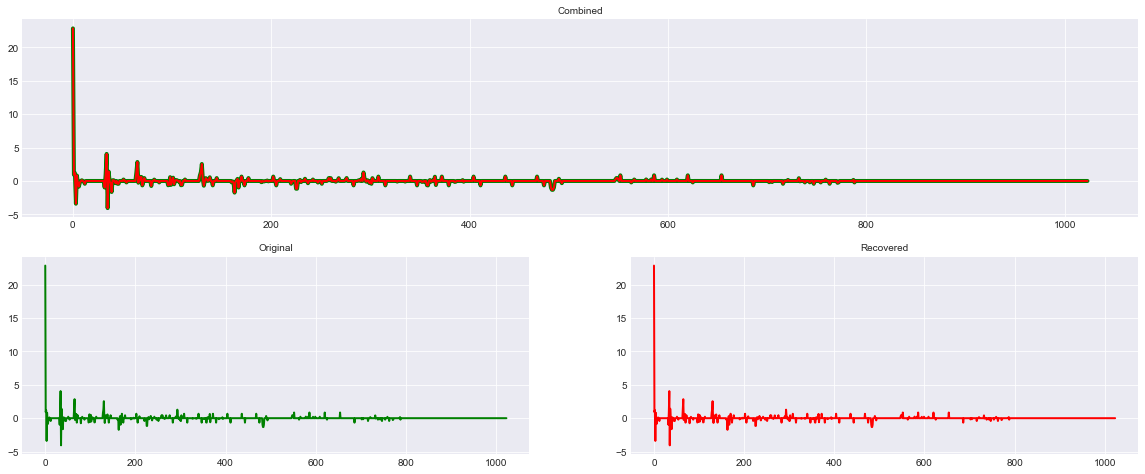

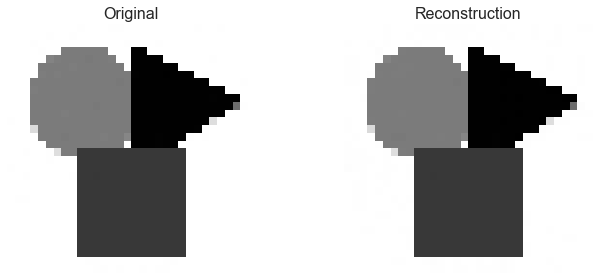

---

For m = 600, s = 286:

L² - recovery error: 0.023563422276446665
L∞ - recovery error: 0.02943008059542762


---


m = 500, s = 286

Feasible (optimal) solution in R^1024 has 508 nonzeros.
Result Vector has 508 non-zeros out of 1024


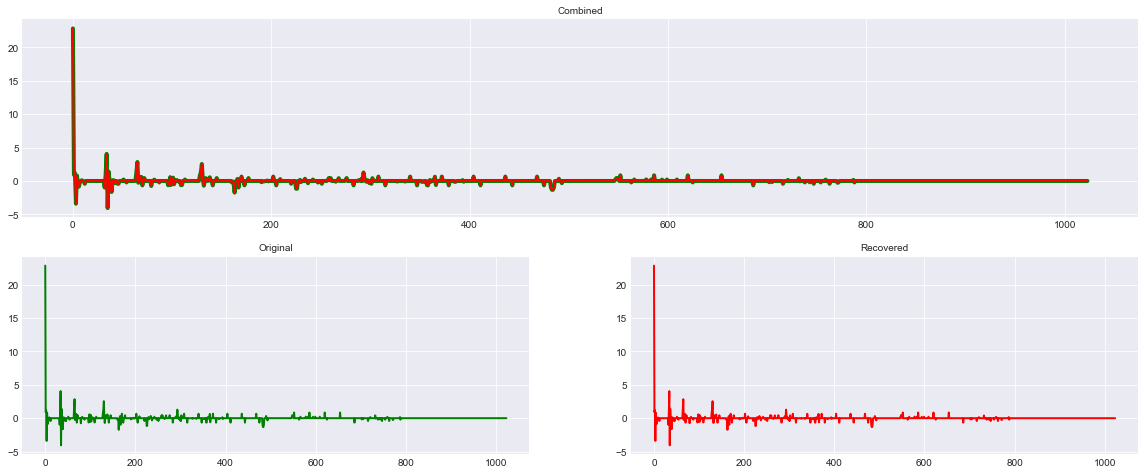

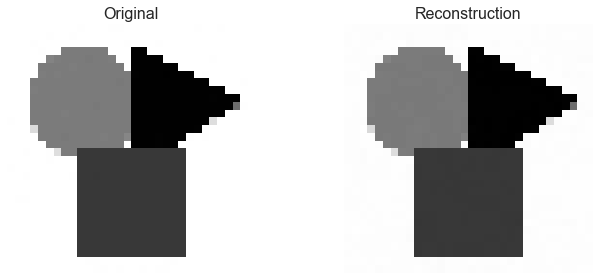

---

For m = 500, s = 286:

L² - recovery error: 0.061029700722415224
L∞ - recovery error: 0.06948547753779197


---


m = 400, s = 286

Feasible (optimal) solution in R^1024 has 408 nonzeros.
Result Vector has 408 non-zeros out of 1024


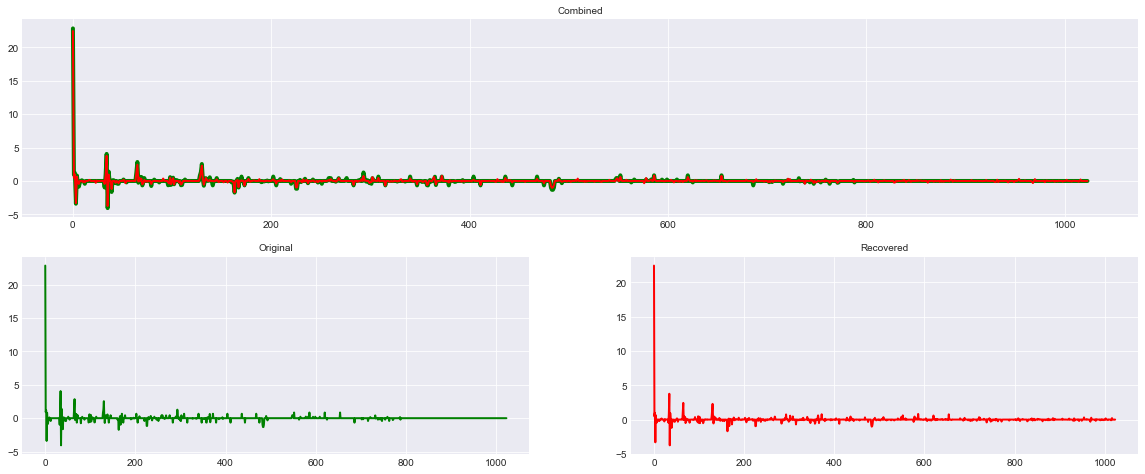

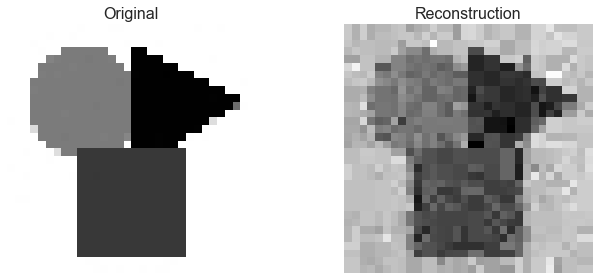

---

For m = 400, s = 286:

L² - recovery error: 3.6181652906702237
L∞ - recovery error: 3.725521816484684


---


m = 300, s = 286

Feasible (optimal) solution in R^1024 has 312 nonzeros.
Result Vector has 312 non-zeros out of 1024


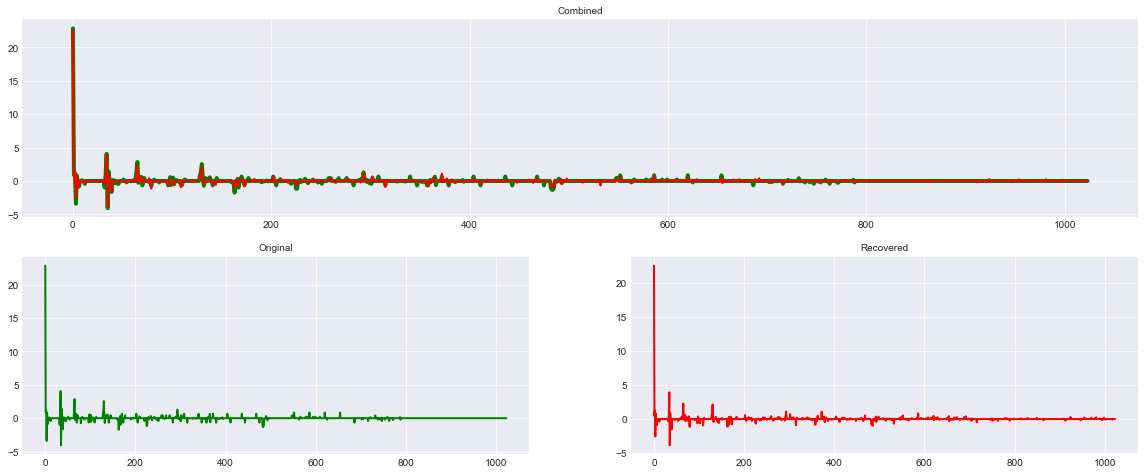

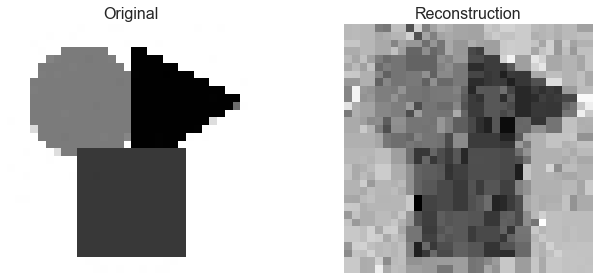

---

For m = 300, s = 286:

L² - recovery error: 4.674728294856581
L∞ - recovery error: 5.2914507532000545


---

In [22]:
from IPython.display import Markdown, display
N = coeffs_arr.size
m = math.floor(.7 * N)
s = math.floor(.4 * m)

# Different m and s values to test
s_test = [(m, 256), (m, 128), (m, 64), (m, 32), (m, 16)]
m_test = [(m, s), (600, s), (500, s), (400, s), (300, s)]

def plot_differences(m, s, N = coeffs_arr.size):

    # Create our sparse input signal from the wavelet coefficients
    x = create_sparse_wavelet_signal(coeffs_arr, s)
    A = create_observation_matrix(m, N)
    y = create_observation_vector(A, x)
    opt_res, xstar = optimize(A, y)

    # Threshold near-zero values and count 'non-zeros'
    z = xstar.copy()
    z[np.abs(z) < 1e-8] = 0
    print('Result Vector has', np.count_nonzero(z), 'non-zeros out of', N)

    # plot the input and recovered vectors
    plot_sparse_vectors(x, z, full=True, title='Combined',  title_a='Original', title_b='Recovered')
    
    # Reshape the reconstructed coefficient array to match the original input image
    coeffs_decode_arr = z.reshape(coeffs_arr.shape)

    # reconstruct the image from the reconstructed coefficient array
    l1_img_recon = reconstruct_image(coeffs_decode_arr, coeffs_slices)

    # Visually verify the reconstruction output
    plot_image_comparison(img_arr, l1_img_recon, 'Original', 'Reconstruction')
    
    # Compute the L2 and Linf recovery error (error between original and reconstructed signals)
    display(Markdown('---'))
    print(f'For m = {m}, s = {s}:\n')
    print('L\u00B2 - recovery error:', np.linalg.norm(x-xstar))
    print('L\u221E - recovery error:', np.linalg.norm(img_arr - l1_img_recon, np.inf))
    display(Markdown('---'))
    
for (m, s) in m_test:
    print(f'\nm = {m}, s = {s}\n')
    plot_differences(m, s)


m = 716, s = 256

Feasible (optimal) solution in R^1024 has 256 nonzeros.
Result Vector has 256 non-zeros out of 1024


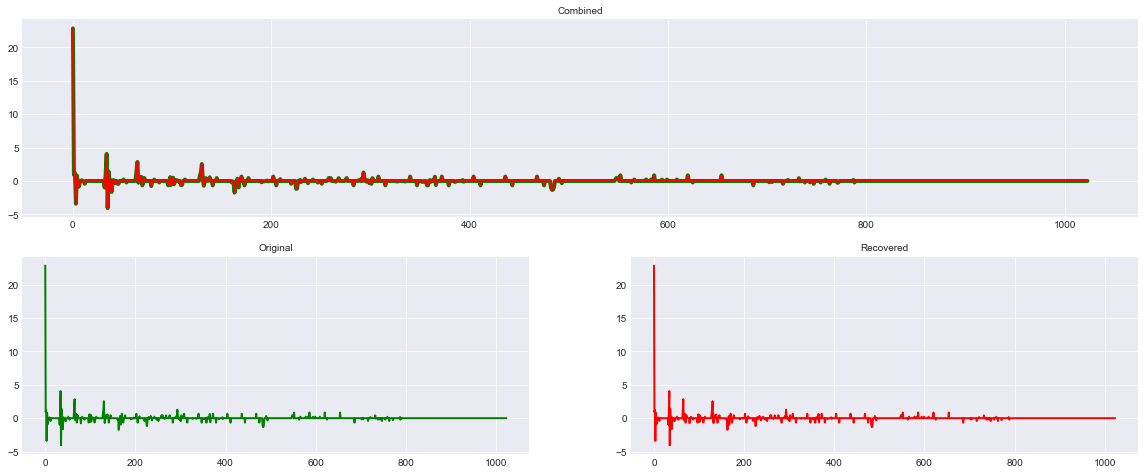

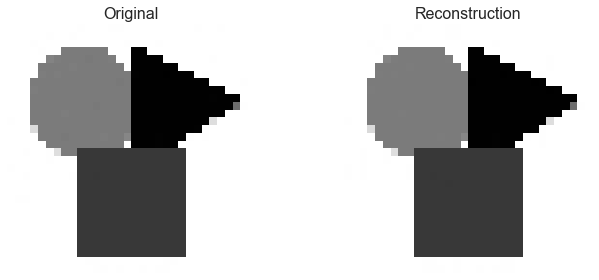

---

For m = 716, s = 256:

L² - recovery error: 8.420399398400378e-10
L∞ - recovery error: 0.016911764829521947


---


m = 716, s = 128

Feasible (optimal) solution in R^1024 has 128 nonzeros.
Result Vector has 128 non-zeros out of 1024


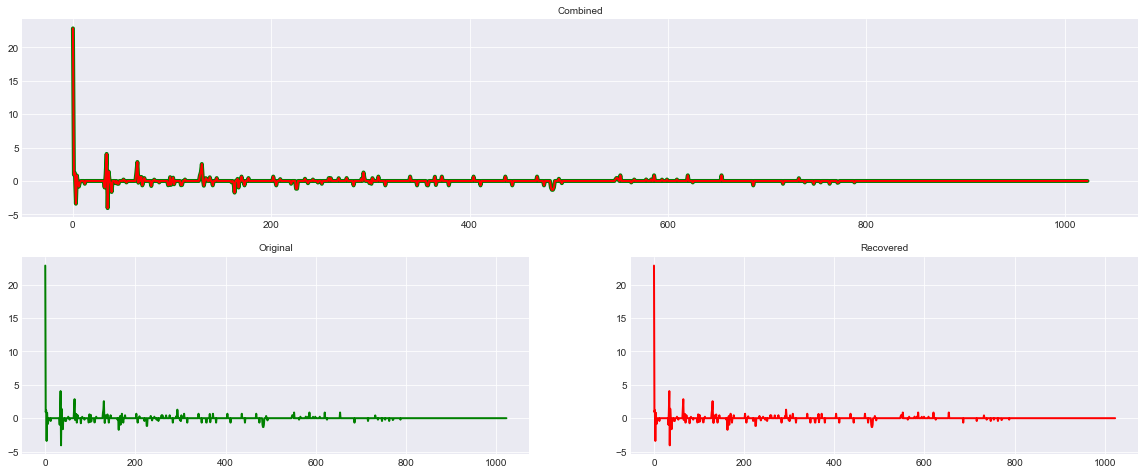

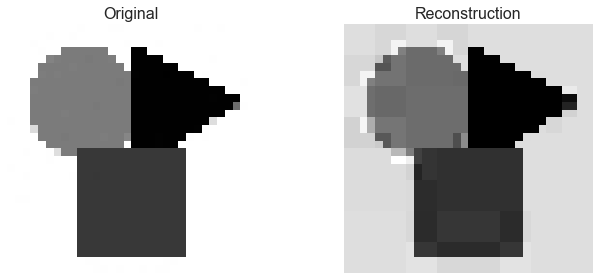

---

For m = 716, s = 128:

L² - recovery error: 3.839434615104939e-10
L∞ - recovery error: 0.8838235295727486


---


m = 716, s = 64

Feasible (optimal) solution in R^1024 has 64 nonzeros.
Result Vector has 64 non-zeros out of 1024


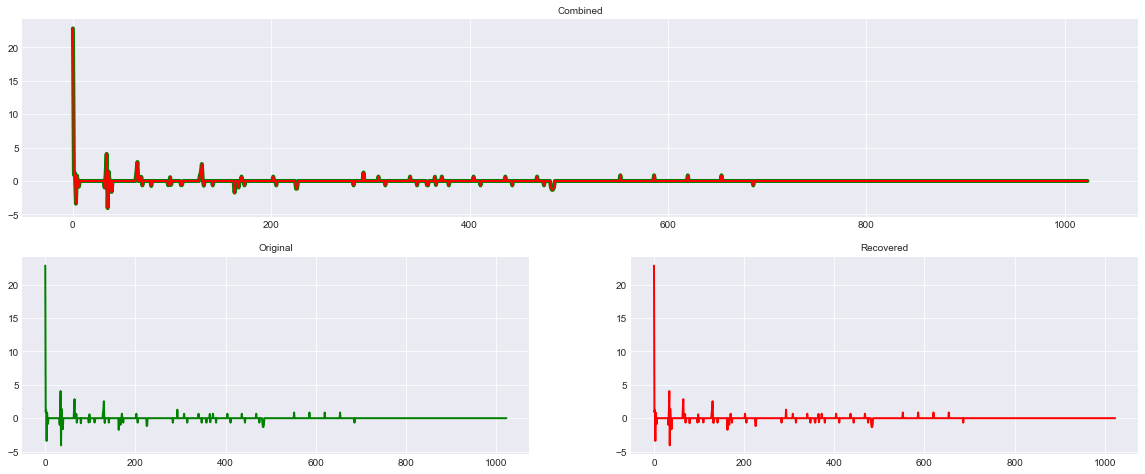

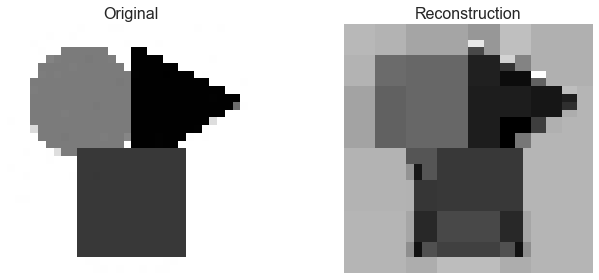

---

For m = 716, s = 64:

L² - recovery error: 6.556511171173294e-09
L∞ - recovery error: 3.8200980400497713


---


m = 716, s = 32

Feasible (optimal) solution in R^1024 has 32 nonzeros.
Result Vector has 32 non-zeros out of 1024


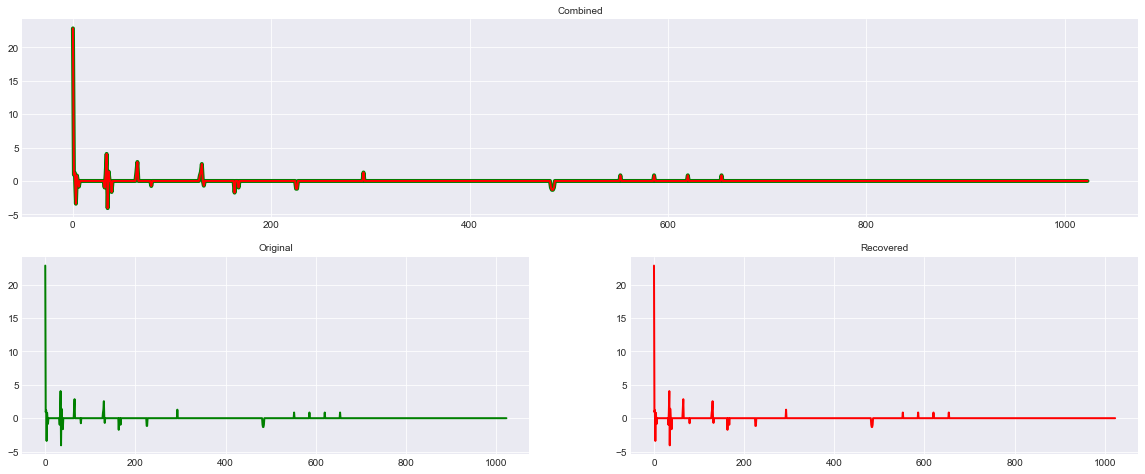

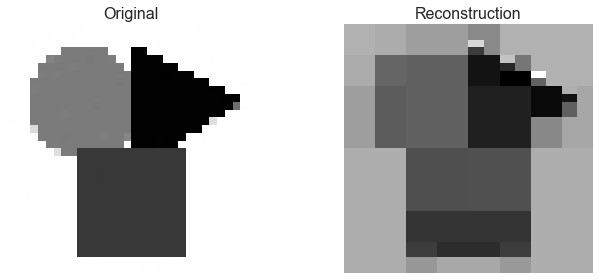

---

For m = 716, s = 32:

L² - recovery error: 1.692541008782014e-09
L∞ - recovery error: 4.388357843669362


---


m = 716, s = 16

Feasible (optimal) solution in R^1024 has 16 nonzeros.
Result Vector has 16 non-zeros out of 1024


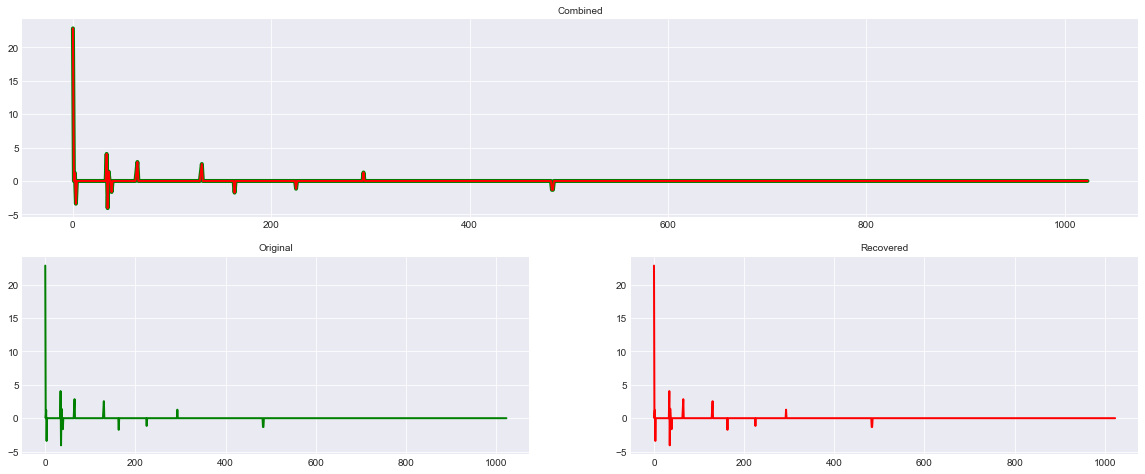

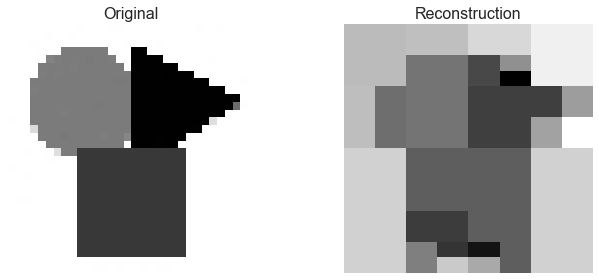

---

For m = 716, s = 16:

L² - recovery error: 1.8551480359916094e-10
L∞ - recovery error: 5.766850490108173


---

In [23]:
for (m, s) in s_test:
    print(f'\nm = {m}, s = {s}\n')
    plot_differences(m, s)